In [ ]:
# This was extremely helpful when setting this lab up:

#https://github.com/peremartra/Large-Language-Model-Notebooks-Course/blob/main/5-Fine%20Tuning/QLoRA_Tuning_PEFT.ipynb

#https://huggingface.co/docs/trl/en/sft_trainer
#https://www.entrypointai.com/blog/lora-fine-tuning/


#https://abvijaykumar.medium.com/fine-tuning-llm-parameter-efficient-fine-tuning-peft-lora-qlora-part-1-571a472612c4

#https://www.mercity.ai/blog-post/guide-to-fine-tuning-llms-with-lora-and-qlora

#https://huggingface.co/blog/unsloth-trl

In [ ]:
https://miro.medium.com/v2/resize:fit:720/format:webp/1*OFO_oWGT2AnFn9o9mvmMvQ.png
https://miro.medium.com/v2/resize:fit:720/format:webp/1*rOW5plKBuMlGgpD0SO8nZA.png

In [1]:
#Importing necesary linbraries
import numpy as np
import math
import matplotlib.pyplot as plt

#Functions to quantize and unquantize
def quantize(value, bits=4):
    quantized_value = np.round(value * (2**(bits - 1) - 1))
    return int(quantized_value)

def unquantize(quantized_value, bits=4):
    value = quantized_value / (2**(bits - 1) - 1)
    return float(value)





quant_4 = quantize(0.622, 4)
print (quant_4)
quant_8 = quantize(0.622, 8)
print(quant_8)





unquant_4 = unquantize(quant_4, 4)
print(unquant_4)
unquant_8 = unquantize(quant_8, 8)
print(unquant_8)



4
79
0.5714285714285714
0.6220472440944882


In [2]:


x = np.linspace(-1, 1, 50)
y = [math.cos(val) for val in x]


y_quant_8bit = np.array([quantize(val, bits=8) for val in y])
y_unquant_8bit = np.array([unquantize(val, bits=8) for val in y_quant_8bit])

y_quant_4bit = np.array([quantize(val, bits=4) for val in y])
y_unquant_4bit = np.array([unquantize(val, bits=4) for val in y_quant_4bit])

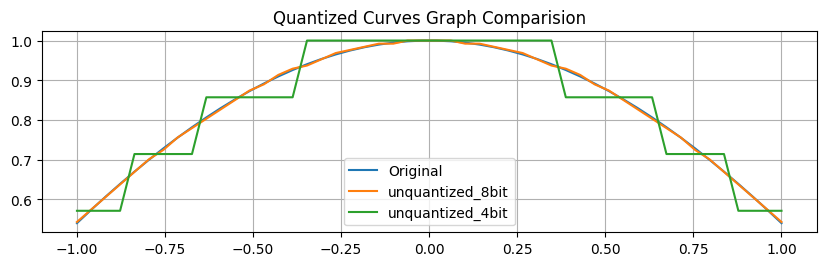

In [3]:
plt.figure(figsize=(10, 12))

plt.subplot(4, 1, 1)
plt.plot(x, y, label="Original")
plt.plot(x, y_unquant_8bit, label="unquantized_8bit")
plt.plot(x, y_unquant_4bit, label="unquantized_4bit")
plt.legend()
plt.title("Quantized Curves Graph Comparision")
plt.grid(True)

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from trl import SFTTrainer
import torch

In [35]:
#model_name = "bigscience/bloom-7b1"

model_name = "bigscience/bloom-7b1"
target_modules = ["q_proj", "v_proj"]

In [44]:


bnb_config = BitsAndBytesConfig(
    load_in_8bit=True
)



In [45]:
import os

In [46]:
token = os.environ['HUGGINGFACE_TOKEN']

In [47]:
from huggingface_hub import login

In [48]:
login(token)

In [49]:


device_map = {"": 0}
foundation_model = AutoModelForCausalLM.from_pretrained(model_name,
                    quantization_config=bnb_config,
                    device_map=device_map,
                    use_cache = False)



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [96]:
keys = list(dict(foundation_model.named_parameters()).keys())

In [98]:
target_modules = ["query_key_value"]

In [97]:
for i in range(len(keys)):
    if target_modules[0] in keys[i]:
        print(keys[i])
    

transformer.h.0.self_attention.query_key_value.weight
transformer.h.0.self_attention.query_key_value.bias
transformer.h.1.self_attention.query_key_value.weight
transformer.h.1.self_attention.query_key_value.bias
transformer.h.2.self_attention.query_key_value.weight
transformer.h.2.self_attention.query_key_value.bias
transformer.h.3.self_attention.query_key_value.weight
transformer.h.3.self_attention.query_key_value.bias
transformer.h.4.self_attention.query_key_value.weight
transformer.h.4.self_attention.query_key_value.bias
transformer.h.5.self_attention.query_key_value.weight
transformer.h.5.self_attention.query_key_value.bias
transformer.h.6.self_attention.query_key_value.weight
transformer.h.6.self_attention.query_key_value.bias
transformer.h.7.self_attention.query_key_value.weight
transformer.h.7.self_attention.query_key_value.bias
transformer.h.8.self_attention.query_key_value.weight
transformer.h.8.self_attention.query_key_value.bias
transformer.h.9.self_attention.query_key_value

In [50]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

In [56]:
def get_outputs(model, inputs, max_new_tokens=100):
    outputs = model.generate(
        input_ids=inputs["input_ids"], # Inputs
        attention_mask=inputs["attention_mask"], # Causal LM --> Only look backwards
        max_new_tokens=max_new_tokens,
        num_beams = 4, # Paths being explored
        repetition_penalty=1.5, # Avoid repetition.
        early_stopping=True, # The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id, # Stop if encountered
    )
    return outputs

In [57]:
input_sentences = tokenizer("What is the main function of FOXP3?", return_tensors="pt").to('cuda')
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=1000)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

['What is the main function of FOXP3? FOXP3 is a member of the forkhead/winged-helix family of transcription factors. It is expressed in Tregs and has been shown to be critical for their suppressive function. In addition, FOXP3 has been shown to play a role in the development and maintenance of Tregs. The mechanism by which FOXP3 exerts its suppressive function is not completely understood. However, it has been shown that FOXP3 interacts with other transcription factors such as GATA-3 and ROR-γt to regulate the expression of genes involved in the suppression of effector T cells. In addition, FOXP3 has been shown to bind to the promoter region of IL-10 and TGF-β, which are important cytokines involved in the suppression of effector T cells. Thus, FOXP3 plays an important role in maintaining the suppressive function of Tregs.\nIn addition to its role in suppressing effector T cells, FOXP3 has also been shown to play a role in the development and maintenance of Tregs. For example, it has 

In [59]:
from datasets import load_dataset
dataset = "openlifescienceai/medmcqa"

#Create the Dataset to create prompts.
data = load_dataset(dataset)



README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/85.9M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/936k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.48M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/182822 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6150 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4183 [00:00<?, ? examples/s]

In [67]:
data['train']

Dataset({
    features: ['id', 'question', 'opa', 'opb', 'opc', 'opd', 'cop', 'choice_type', 'exp', 'subject_name', 'topic_name'],
    num_rows: 182822
})

In [69]:
data

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'opa', 'opb', 'opc', 'opd', 'cop', 'choice_type', 'exp', 'subject_name', 'topic_name', 'input_ids', 'attention_mask'],
        num_rows: 182822
    })
    test: Dataset({
        features: ['id', 'question', 'opa', 'opb', 'opc', 'opd', 'cop', 'choice_type', 'exp', 'subject_name', 'topic_name', 'input_ids', 'attention_mask'],
        num_rows: 6150
    })
    validation: Dataset({
        features: ['id', 'question', 'opa', 'opb', 'opc', 'opd', 'cop', 'choice_type', 'exp', 'subject_name', 'topic_name', 'input_ids', 'attention_mask'],
        num_rows: 4183
    })
})

In [70]:
data = data.map(lambda samples: tokenizer(samples["question"]), batched=True)


Map:   0%|          | 0/182822 [00:00<?, ? examples/s]

Map:   0%|          | 0/6150 [00:00<?, ? examples/s]

Map:   0%|          | 0/4183 [00:00<?, ? examples/s]

AttributeError: 'list' object has no attribute 'select'

In [83]:
train_sample = data["train"].select(range(50))


In [84]:
train_sample

Dataset({
    features: ['id', 'question', 'opa', 'opb', 'opc', 'opd', 'cop', 'choice_type', 'exp', 'subject_name', 'topic_name', 'input_ids', 'attention_mask'],
    num_rows: 50
})

In [85]:
train_sample['question'][0]

'Chronic urethral obstruction due to benign prismatic hyperplasia can lead to the following change in kidney parenchyma'

In [86]:
train_sample['exp'][0]

'Chronic urethral obstruction because of urinary calculi, prostatic hyperophy, tumors, normal pregnancy, tumors, uterine prolapse or functional disorders cause hydronephrosis which by definition is used to describe dilatation of renal pelvis and calculus associated with progressive atrophy of the kidney due to obstruction to the outflow of urine Refer Robbins 7yh/9,1012,9/e. P950'

In [87]:

train_sample = train_sample.remove_columns(['id','opa','opb','opc','cop','opd','choice_type','subject_name','topic_name'])

display(train_sample)



Dataset({
    features: ['question', 'exp', 'input_ids', 'attention_mask'],
    num_rows: 50
})

In [99]:
import peft
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=8, # Rank adaptation
    lora_alpha=10, # Weighting of the new training
    target_modules=target_modules,
    lora_dropout=0.05, # 
    bias="none", # this specifies if the bias parameter should be trained.
    task_type="CAUSAL_LM"
)

In [101]:
os.makedirs('/mnt/data/peft',exist_ok=True)

In [112]:
from trl import SFTConfig, SFTTrainer
import transformers
from transformers import TrainingArguments # , Trainer


In [113]:
training_args = SFTConfig(learning_rate=2e-4, auto_find_batch_size=True,num_train_epochs=5)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [106]:
help(SFTTrainer)

Help on class SFTTrainer in module trl.trainer.sft_trainer:

class SFTTrainer(transformers.trainer.Trainer)
 |  SFTTrainer(model: Union[str, torch.nn.modules.module.Module, transformers.modeling_utils.PreTrainedModel], args: Union[trl.trainer.sft_config.SFTConfig, transformers.training_args.TrainingArguments, NoneType] = None, data_collator: Optional[DataCollator] = None, train_dataset: Union[datasets.arrow_dataset.Dataset, datasets.iterable_dataset.IterableDataset, NoneType] = None, eval_dataset: Union[datasets.arrow_dataset.Dataset, dict[str, datasets.arrow_dataset.Dataset], NoneType] = None, processing_class: Union[transformers.tokenization_utils_base.PreTrainedTokenizerBase, transformers.image_processing_utils.BaseImageProcessor, transformers.feature_extraction_utils.FeatureExtractionMixin, transformers.processing_utils.ProcessorMixin, NoneType] = None, compute_loss_func: Optional[Callable] = None, compute_metrics: Optional[Callable[[transformers.trainer_utils.EvalPrediction], dict

In [111]:
dataset_test['text'][0]

'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.'

In [115]:


tokenizer.pad_token = tokenizer.eos_token
trainer = SFTTrainer(
    model = foundation_model,
    train_dataset = train_sample,
    args = training_args,
    peft_config = lora_config
)
trainer.train()



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/home/nikolas/miniconda3/lib/python3.9/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss


Step,Training Loss


TrainOutput(global_step=65, training_loss=3.2624070387620194, metrics={'train_runtime': 23.1524, 'train_samples_per_second': 10.798, 'train_steps_per_second': 2.807, 'total_flos': 360326668517376.0, 'train_loss': 3.2624070387620194})

In [116]:
train_sample = data["train"].select(range(1000))


In [117]:


tokenizer.pad_token = tokenizer.eos_token
trainer = SFTTrainer(
    model = foundation_model,
    train_dataset = train_sample,
    args = training_args,
    peft_config = lora_config
)
trainer.train()



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/nikolas/miniconda3/lib/python3.9/site-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/home/nikolas/miniconda3/lib/python3.9/site-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Truncating train dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/home/nikolas/miniconda3/lib/python3.9/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss


Step,Training Loss
500,2.863800
1000,2.228400


/home/nikolas/miniconda3/lib/python3.9/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/nikolas/miniconda3/lib/python3.9/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


TrainOutput(global_step=1250, training_loss=2.4021791259765624, metrics={'train_runtime': 425.2257, 'train_samples_per_second': 11.758, 'train_steps_per_second': 2.94, 'total_flos': 6199911092846592.0, 'train_loss': 2.4021791259765624})

In [118]:
training_args = SFTConfig(learning_rate=2e-4, auto_find_batch_size=True,num_train_epochs=5,neftune_noise_alpha=5)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [120]:


tokenizer.pad_token = tokenizer.eos_token
trainer = SFTTrainer(
    model = foundation_model,
    train_dataset = train_sample,
    args = training_args,
    peft_config = lora_config
)
trainer.train()



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/nikolas/miniconda3/lib/python3.9/site-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/home/nikolas/miniconda3/lib/python3.9/site-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, 

Step,Training Loss


Step,Training Loss
500,3.116600
1000,2.633200


/home/nikolas/miniconda3/lib/python3.9/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/nikolas/miniconda3/lib/python3.9/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")

KeyboardInterrupt



In [ ]:
import torch
from trl import SFTConfig, SFTTrainer
from unsloth import FastLanguageModel

max_length = 1024 # Supports automatic RoPE Scaling, so choose any number

# Load model
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="meta-llama/Llama-2-7b-hf",
    max_seq_length=max_length,
    dtype=None,  # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
    load_in_4bit=True,  # Use 4bit quantization to reduce memory usage. Can be False
    token = os.environ['HUGGINGFACE_TOKEN']
)

# Do model patching and add fast LoRA weights
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
    lora_alpha=16,
    lora_dropout=0,  # Dropout = 0 is currently optimized
    bias="none",  # Bias = "none" is currently optimized
    use_gradient_checkpointing=True,
    random_state=3407,
)

training_args = SFTConfig(output_dir="./output", max_length=max_length)

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
)
trainer.train()

In [ ]:


tokenizer.pad_token = tokenizer.eos_token
trainer = SFTTrainer(
    model = foundation_model,
    train_dataset = train_sample,
    args = training_args,
    peft_config = lora_config
)
trainer.train()



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/nikolas/miniconda3/lib/python3.9/site-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/home/nikolas/miniconda3/lib/python3.9/site-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, 

Step,Training Loss


Step,Training Loss
500,2.962600


/home/nikolas/miniconda3/lib/python3.9/site-packages/peft/utils/other.py:1110: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer')), '(Request ID: 763ed031-85e4-4b77-ad3d-e7e4fad2afab)') - silently ignoring the lookup for the file config.json in bigscience/bloom-7b1.
  warnings.warn(
/home/nikolas/miniconda3/lib/python3.9/site-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in bigscience/bloom-7b1 - will assume that the vocabulary was not modified.
  warnings.warn(
/home/nikolas/miniconda3/lib/python3.9/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
